# Auto Encoders and Variational Auto Encoders on MNIST

In this notebook we are going to demonstrate Auto Encoder and Variational Auto Encoder models on MNIST data.  

We will go through many visualizations to develop good intuition on how these models work.

### Set GPU for Runtime

<p id="7ecb" class="gy gz ef at ha b hb ja hd jb hf jc hh jd hj je hl" data-selectable-paragraph="">It is so simple to alter default hardware <strong class="ha hm">(CPU to GPU or vice versa)</strong>; just follow <strong class="ha hm">Edit &gt; Notebook settings</strong> or <strong class="ha hm">Runtime&gt;Change runtime type </strong>and <strong class="ha hm">select GPU </strong>as <strong class="ha hm">Hardware accelerator</strong>.</p>

![tittle](https://miro.medium.com/max/740/1*WNovJnpGMOys8Rv7YIsZzA.png)

### Imports

In [24]:
# Python lib
import os
from typing import List, Tuple

# Scientific utilities
import numpy as np
import pandas as pd
from scipy.stats import norm as ndist

# PyTorch
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

# Vizualisations
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

### Globals

In [4]:
DATA_DIR = 'data'

BATCH_SIZE = 128

### Preparing Data

Conveniently, PyTorch comes with pre-defined MNIST dataset so we are going to use it directly.

In [5]:
def get_mnist_ds(train: bool):

    return torchvision.datasets.MNIST(DATA_DIR, 
                                      train=train, 
                                      transform=transforms.Compose([
                                                    transforms.ToTensor(),
                                                ]), 
                                      target_transform=None, 
                                      download=True)

def get_mnist_dls():
    
    train_ds = get_mnist_ds(train=True)
    valid_ds = get_mnist_ds(train=False)
    
    return (torch.utils.data.DataLoader(train_ds, 
                                        batch_size=BATCH_SIZE, 
                                        shuffle=True, 
                                        pin_memory=False),
            
            torch.utils.data.DataLoader(valid_ds, 
                                        batch_size=2 * BATCH_SIZE, 
                                        shuffle=False, 
                                        pin_memory=False))

train_dl, valid_dl = get_mnist_dls()

len(train_dl.dataset), len(valid_dl.dataset)

  0%|          | 0/9912422 [00:00<?, ?it/s]

9920512it [00:00, 26096254.78it/s]                            


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


32768it [00:00, 492879.49it/s]
  1%|          | 16384/1648877 [00:00<00:10, 152169.91it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw


1654784it [00:00, 7502199.26it/s]                            
8192it [00:00, 203490.27it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw
Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!


(60000, 10000)

torch.Size([128, 1, 28, 28]) tensor(0.1289) tensor(0.3063) tensor(0.) tensor(1.)


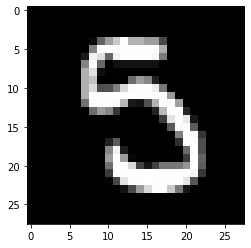

torch.Size([128, 1, 28, 28]) tensor(0.1356) tensor(0.3136) tensor(0.) tensor(1.)


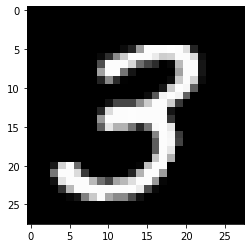

torch.Size([128, 1, 28, 28]) tensor(0.1279) tensor(0.3046) tensor(0.) tensor(1.)


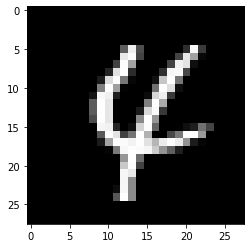

torch.Size([128, 1, 28, 28]) tensor(0.1331) tensor(0.3099) tensor(0.) tensor(1.)


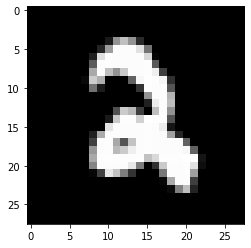

In [6]:
# displaying some of the images with some stats. 

for i, (x, y) in enumerate(train_dl):
    print(x.shape, x.mean(), x.std(), x.min(), x.max())
    plt.imshow(x[0][0], cmap='gray')
    plt.show()
    if i > 2: break

## Training Vanilla Auto Encoder

In [7]:
# this is helper function for initializing weights of the model.

def init_weights(m: nn.Module):

    for m in m.modules():
        if isinstance(m, nn.Linear):
            nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
            nn.init.constant_(m.bias, 0)

We fill be using simle encoder with one hidden layer and Relu activation

In [8]:
class Encoder(nn.Module):
    def __init__(self, inp_shape: Tuple[int, int], hidden_dim: int, out_dim: int):
        super().__init__()
        
        self.enc = nn.Sequential(nn.Flatten(),
                                 nn.Linear(np.prod(inp_shape), hidden_dim),
                                 nn.ReLU(),
                                 nn.Linear(hidden_dim, out_dim))
        
        init_weights(self)
        
    def forward(self, x): return self.enc(x)

In [9]:
m = Encoder(inp_shape=(28, 28), hidden_dim=512, out_dim=256)
m

Encoder(
  (enc): Sequential(
    (0): Flatten()
    (1): Linear(in_features=784, out_features=512, bias=True)
    (2): ReLU()
    (3): Linear(in_features=512, out_features=256, bias=True)
  )
)

In [10]:
class Decoder(nn.Module):
    def __init__(self, inp_shape: Tuple[int, int], hidden_dim: int, out_dim: int):
        super().__init__()
        
        self.inp_shape = inp_shape
        
        self.dec = nn.Sequential(nn.Linear(out_dim, hidden_dim),
                                 nn.ReLU(),
                                 nn.Linear(hidden_dim, np.prod(inp_shape)))
        
        init_weights(self)
        
    def forward(self, x): return torch.sigmoid(self.dec(x)).view(x.shape[0], *self.inp_shape)

In [11]:
m = Decoder(inp_shape=(28, 28), hidden_dim=512, out_dim=256)
m

Decoder(
  (dec): Sequential(
    (0): Linear(in_features=256, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=784, bias=True)
  )
)

In [12]:
# here we just combine encoder and decoder modules from above

class AutoEncoder(nn.Module):
    def __init__(self, inp_shape: Tuple[int, int], hidden_dim: int, out_dim: int):
        super().__init__()
        
        self.ae = nn.Sequential(Encoder(inp_shape, hidden_dim, out_dim),
                                Decoder(inp_shape, hidden_dim, out_dim))
        
    def forward(self, x): return self.ae(x)

In [13]:
m = AutoEncoder(inp_shape=(1, 28, 28), hidden_dim=512, out_dim=256)
m

AutoEncoder(
  (ae): Sequential(
    (0): Encoder(
      (enc): Sequential(
        (0): Flatten()
        (1): Linear(in_features=784, out_features=512, bias=True)
        (2): ReLU()
        (3): Linear(in_features=512, out_features=256, bias=True)
      )
    )
    (1): Decoder(
      (dec): Sequential(
        (0): Linear(in_features=256, out_features=512, bias=True)
        (1): ReLU()
        (2): Linear(in_features=512, out_features=784, bias=True)
      )
    )
  )
)

In [14]:
# we make sure that auto encoder output has same shape as the input

o = torch.randn(BATCH_SIZE, 1, 28, 28)
assert m(o).shape == o.shape

In [15]:
def show_summary(valid_dl: DataLoader, model: nn.Module):
    """This is a helper function for visualizing model output quality during the training process."""
    
    N_SAMPLES = 15
    
    model.eval()
    
    actuals, preds = [], []
    with torch.no_grad():
        for i, (x, y) in enumerate(valid_dl.dataset):
            
            actuals.append(x)
            
            recon_x = model(x.unsqueeze(0).cuda()).cpu()
            
            preds.append(recon_x.squeeze(0))
            
            if i + 1 == N_SAMPLES:
                break
                
    model.train()
            
    grid = make_grid([*actuals, *preds], pad_value=1, padding=1, nrow=N_SAMPLES)

    plt.figure(figsize=(20, 4))
    plt.imshow(grid.permute(1, 2, 0))
    plt.axis('off')
    plt.show()
        
def train_ae(train_dl: DataLoader, 
             valid_dl: DataLoader,
             model: nn.Module,
             n_epochs: int,
             max_iters: int = -1):
    """Training Loop"""
    
    LOG_INTERVAL = 5
    SUMMARY_INTERVAL = 10
    
    model = model.cuda() # moving our model on GPU.
    
    # defining loss function and optimizer (we will use Adam here)
    crit = nn.MSELoss(reduction='mean')
    optim = torch.optim.Adam(model.parameters())
    
    acc_loss = 0
    
    i = 1
    for epoch in range(n_epochs):
        for x, _ in train_dl:
            
            optim.zero_grad()
            
            x = x.cuda()
            
            x_recon = model(x)
            
            loss = crit(x, x_recon)
            
            acc_loss += loss.item()
            
            loss.backward() # computing the gradients
            
            optim.step() # updating model weights
            
            if (i + 1) % LOG_INTERVAL == 0:
                print('epoch %d | iter %d | loss %.5f' % (epoch + 1, i + 1, acc_loss / LOG_INTERVAL))
                acc_loss = 0
                
            if (i + 1) % SUMMARY_INTERVAL == 0:
                show_summary(valid_dl, model)
                
            i += 1
            
            if i == max_iters:
                return

Now we will train the mode. You can play with out_dim parameter (latent vector size) and see how it affects training speed and image restoration quality

epoch 1 | iter 5 | loss 0.17003
epoch 1 | iter 10 | loss 0.11973


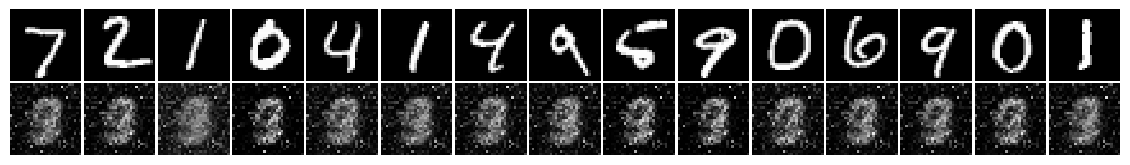

epoch 1 | iter 15 | loss 0.07783
epoch 1 | iter 20 | loss 0.06992


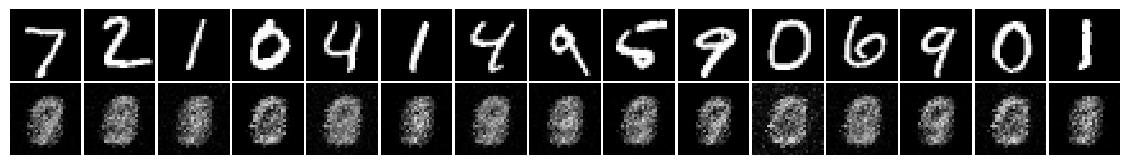

epoch 1 | iter 25 | loss 0.06517
epoch 1 | iter 30 | loss 0.06065


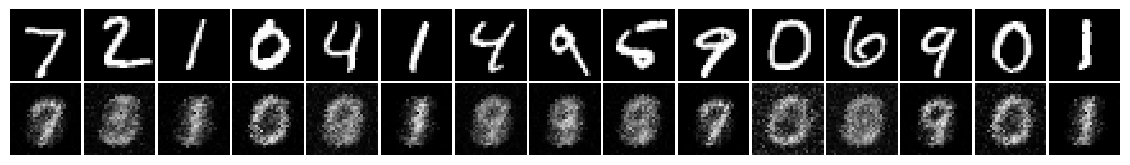

epoch 1 | iter 35 | loss 0.05501
epoch 1 | iter 40 | loss 0.05348


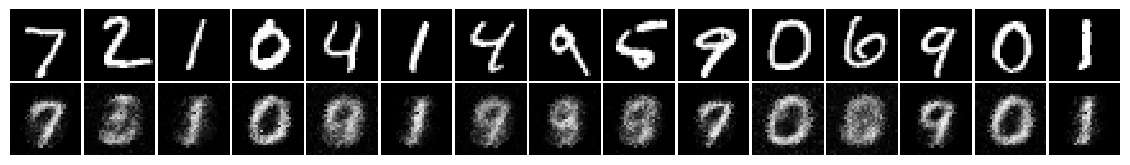

epoch 1 | iter 45 | loss 0.05030
epoch 1 | iter 50 | loss 0.04748


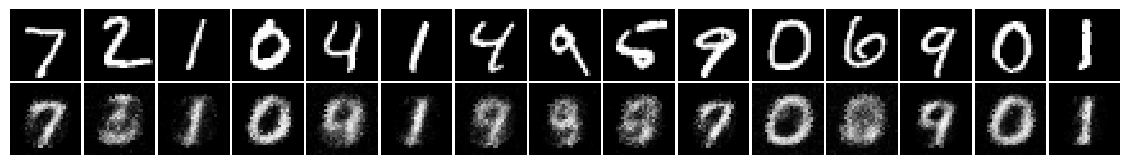

epoch 1 | iter 55 | loss 0.04392
epoch 1 | iter 60 | loss 0.04063


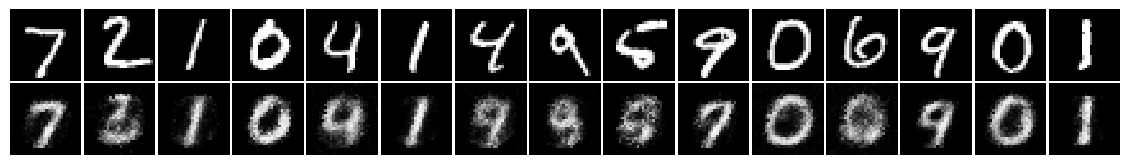

epoch 1 | iter 65 | loss 0.03840
epoch 1 | iter 70 | loss 0.03573


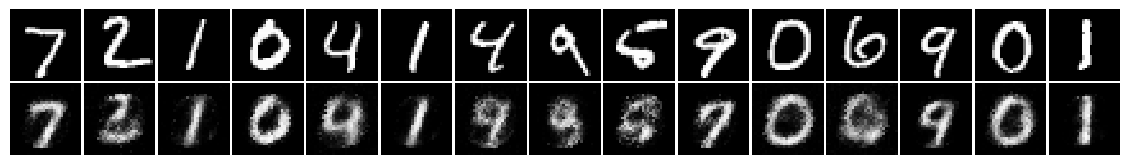

epoch 1 | iter 75 | loss 0.03499
epoch 1 | iter 80 | loss 0.03366


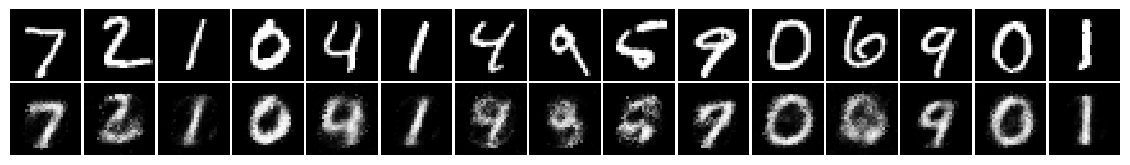

epoch 1 | iter 85 | loss 0.03208
epoch 1 | iter 90 | loss 0.03119


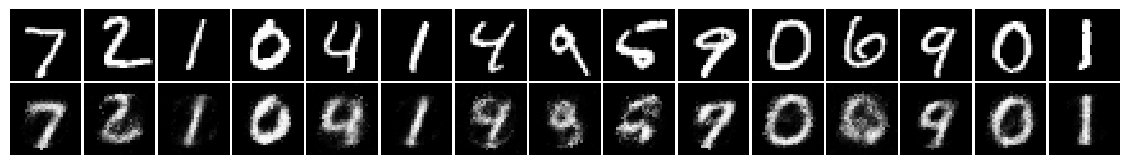

epoch 1 | iter 95 | loss 0.02907
epoch 1 | iter 100 | loss 0.02986


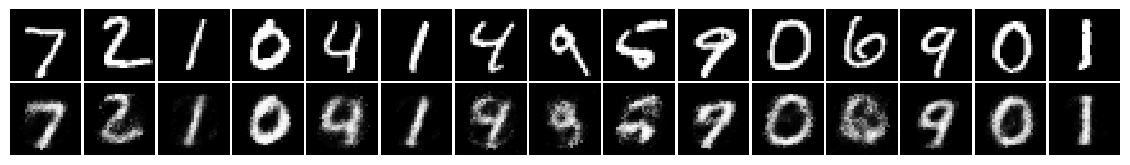

epoch 1 | iter 105 | loss 0.02889
epoch 1 | iter 110 | loss 0.02775


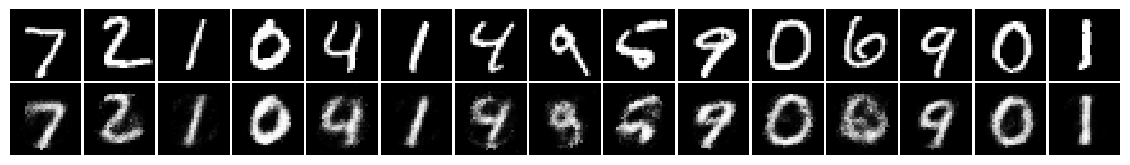

epoch 1 | iter 115 | loss 0.02607
epoch 1 | iter 120 | loss 0.02668


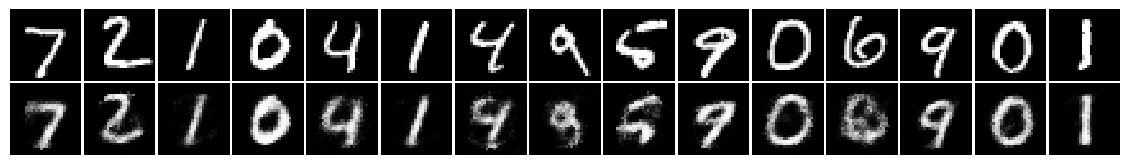

epoch 1 | iter 125 | loss 0.02530
epoch 1 | iter 130 | loss 0.02576


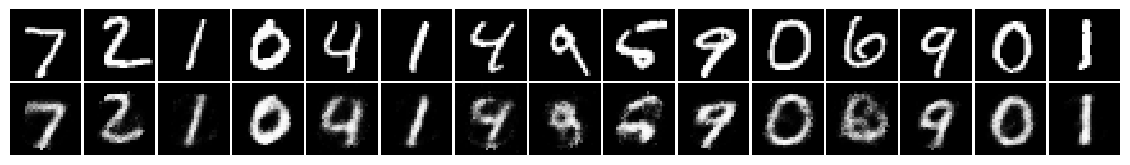

epoch 1 | iter 135 | loss 0.02431
epoch 1 | iter 140 | loss 0.02453


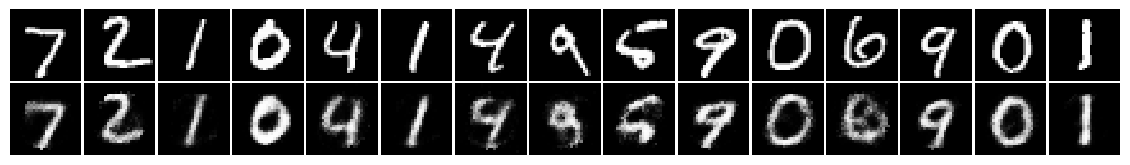

epoch 1 | iter 145 | loss 0.02357
epoch 1 | iter 150 | loss 0.02323


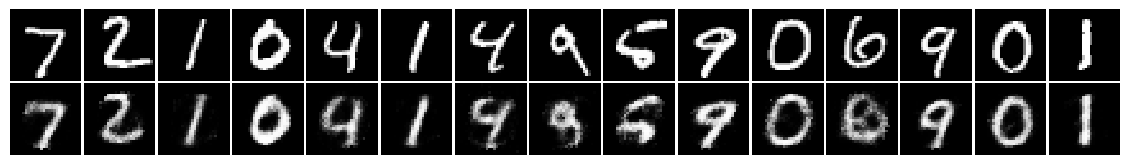

epoch 1 | iter 155 | loss 0.02299
epoch 1 | iter 160 | loss 0.02238


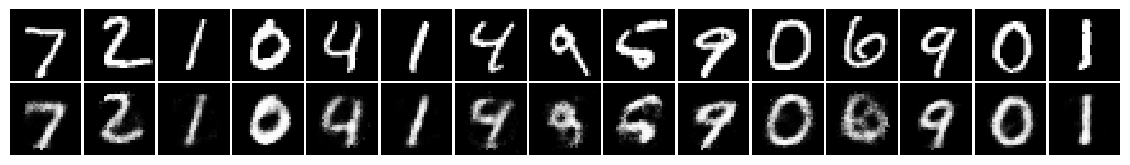

epoch 1 | iter 165 | loss 0.02167
epoch 1 | iter 170 | loss 0.02203


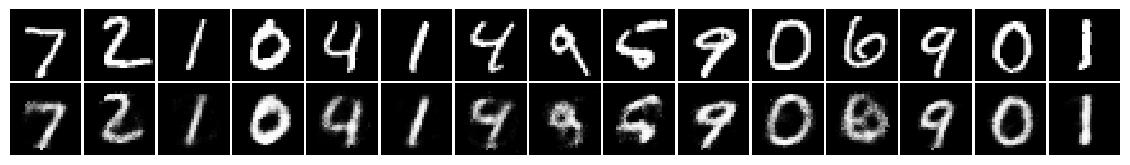

epoch 1 | iter 175 | loss 0.02268
epoch 1 | iter 180 | loss 0.02182


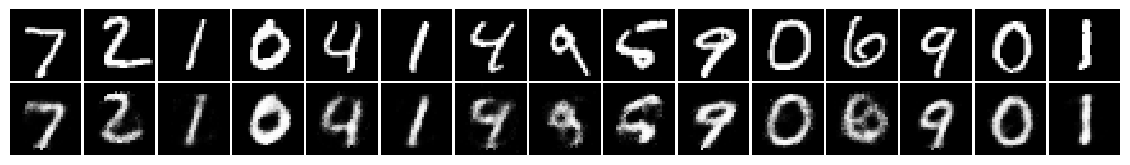

epoch 1 | iter 185 | loss 0.02086
epoch 1 | iter 190 | loss 0.02149


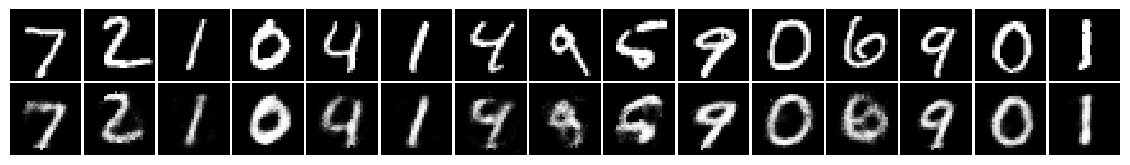

epoch 1 | iter 195 | loss 0.02073
epoch 1 | iter 200 | loss 0.02024


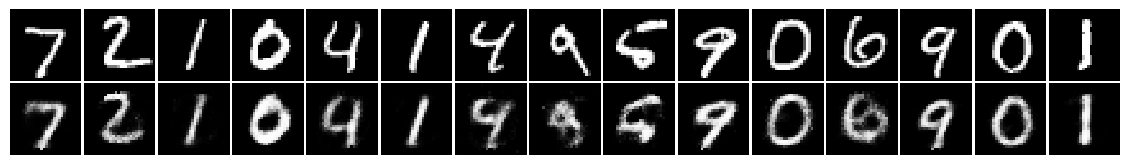

epoch 1 | iter 205 | loss 0.02076
epoch 1 | iter 210 | loss 0.02051


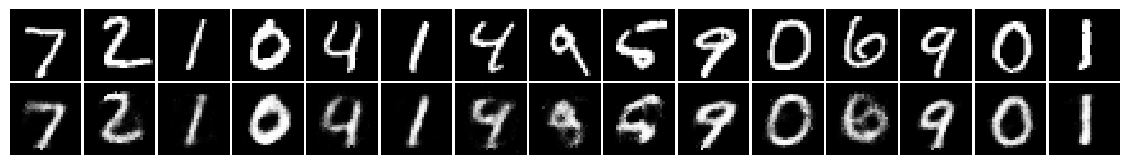

epoch 1 | iter 215 | loss 0.01955
epoch 1 | iter 220 | loss 0.01969


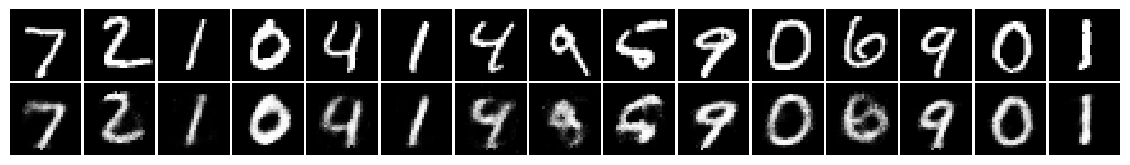

epoch 1 | iter 225 | loss 0.01989
epoch 1 | iter 230 | loss 0.02006


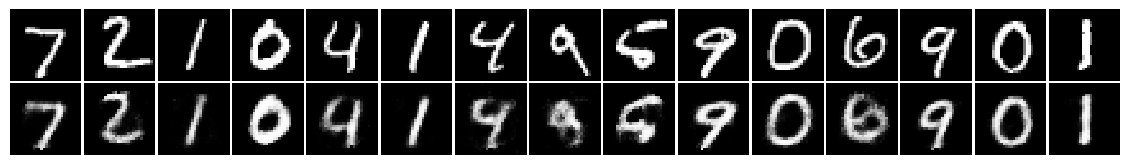

epoch 1 | iter 235 | loss 0.01920
epoch 1 | iter 240 | loss 0.01895


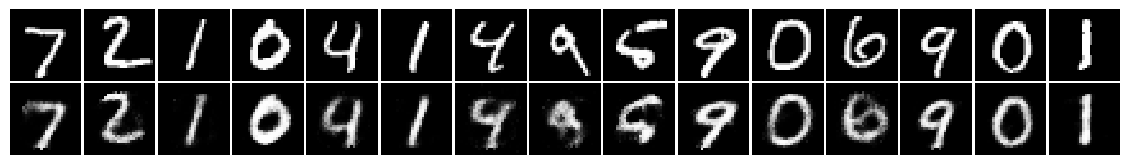

epoch 1 | iter 245 | loss 0.01918
epoch 1 | iter 250 | loss 0.01875


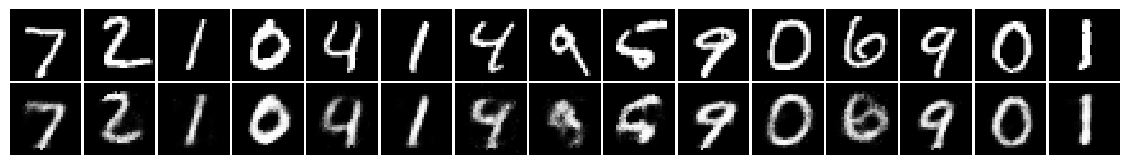

epoch 1 | iter 255 | loss 0.01833
epoch 1 | iter 260 | loss 0.01800


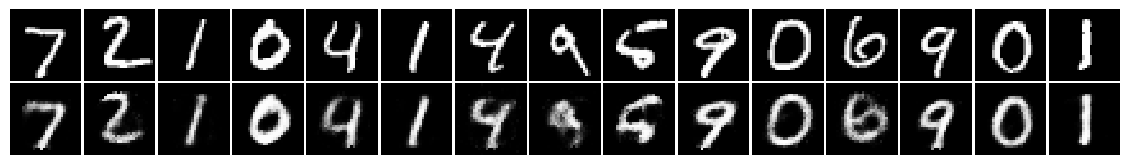

epoch 1 | iter 265 | loss 0.01764
epoch 1 | iter 270 | loss 0.01842


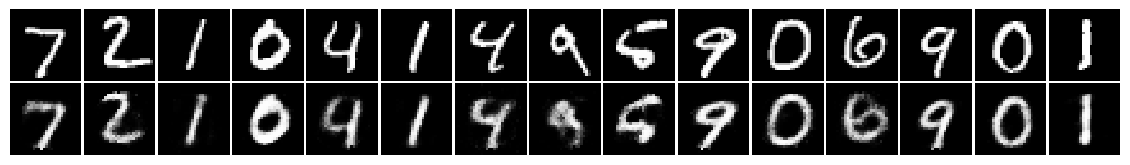

epoch 1 | iter 275 | loss 0.01779
epoch 1 | iter 280 | loss 0.01720


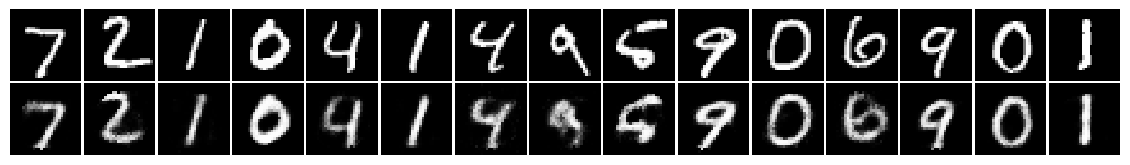

epoch 1 | iter 285 | loss 0.01779
epoch 1 | iter 290 | loss 0.01725


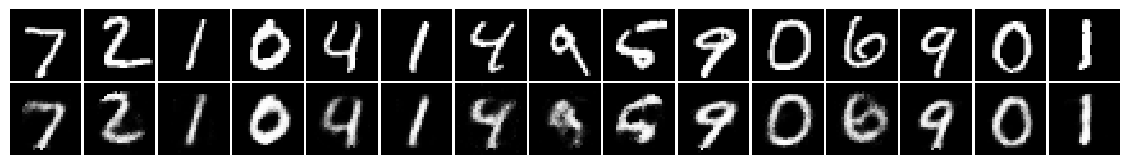

epoch 1 | iter 295 | loss 0.01732
epoch 1 | iter 300 | loss 0.01857


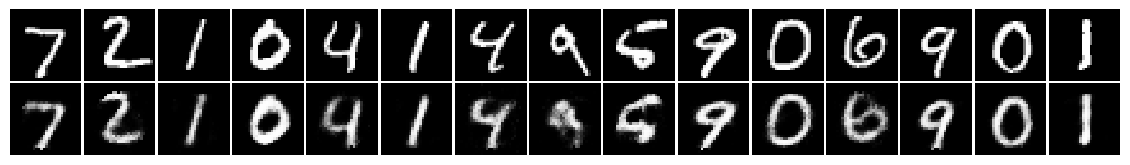

epoch 1 | iter 305 | loss 0.01773
epoch 1 | iter 310 | loss 0.01741


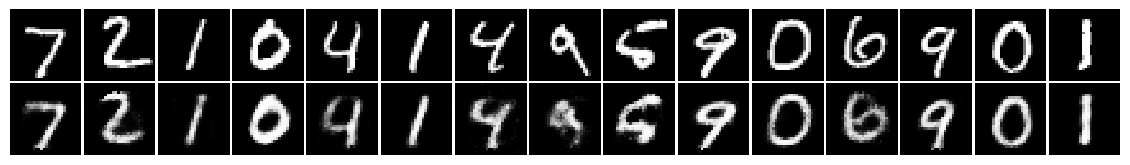

epoch 1 | iter 315 | loss 0.01724
epoch 1 | iter 320 | loss 0.01779


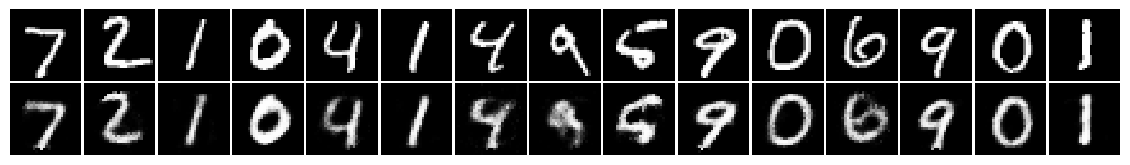

epoch 1 | iter 325 | loss 0.01784
epoch 1 | iter 330 | loss 0.01683


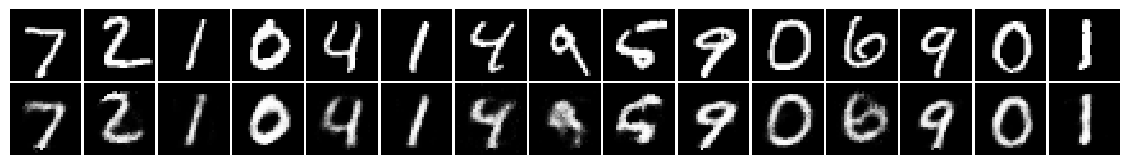

epoch 1 | iter 335 | loss 0.01761
epoch 1 | iter 340 | loss 0.01736


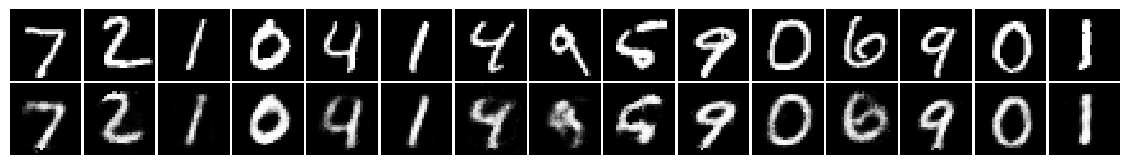

epoch 1 | iter 345 | loss 0.01691
epoch 1 | iter 350 | loss 0.01679


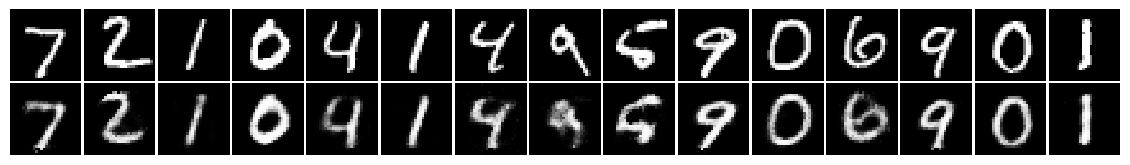

epoch 1 | iter 355 | loss 0.01688
epoch 1 | iter 360 | loss 0.01677


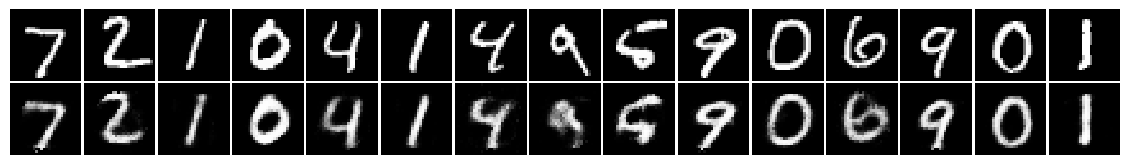

epoch 1 | iter 365 | loss 0.01573
epoch 1 | iter 370 | loss 0.01593


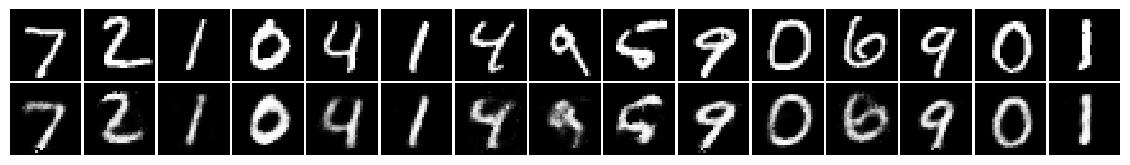

epoch 1 | iter 375 | loss 0.01592
epoch 1 | iter 380 | loss 0.01637


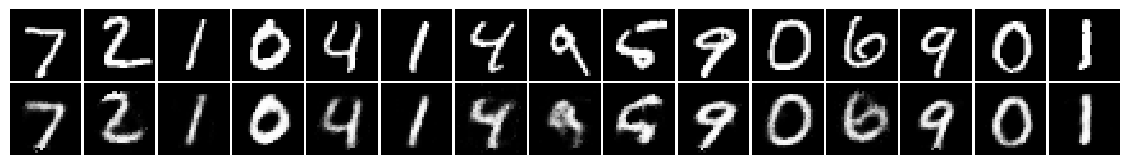

epoch 1 | iter 385 | loss 0.01620
epoch 1 | iter 390 | loss 0.01652


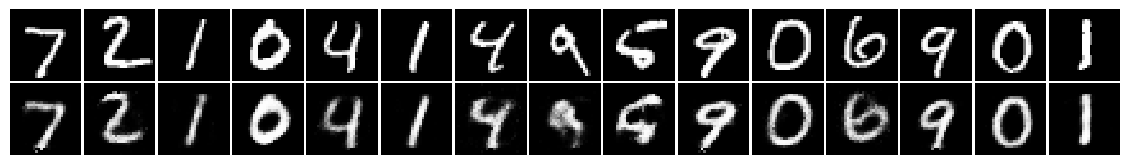

epoch 1 | iter 395 | loss 0.01612
epoch 1 | iter 400 | loss 0.01591


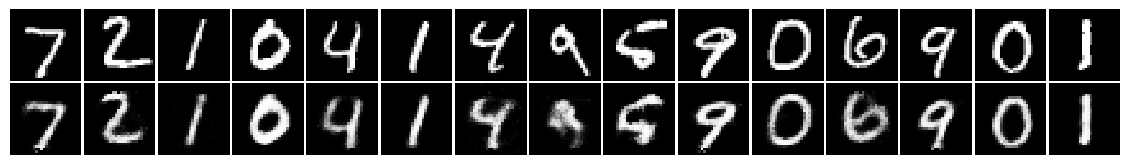

epoch 1 | iter 405 | loss 0.01535
epoch 1 | iter 410 | loss 0.01591


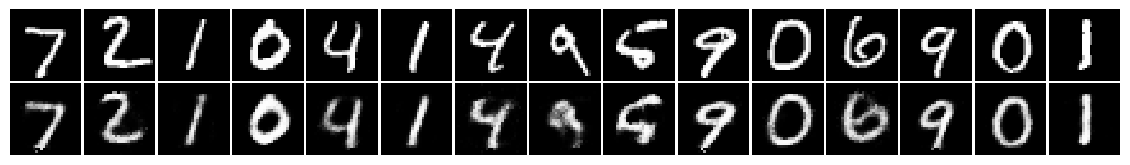

epoch 1 | iter 415 | loss 0.01566
epoch 1 | iter 420 | loss 0.01588


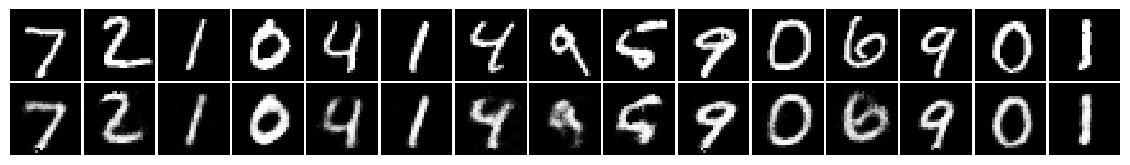

epoch 1 | iter 425 | loss 0.01574
epoch 1 | iter 430 | loss 0.01553


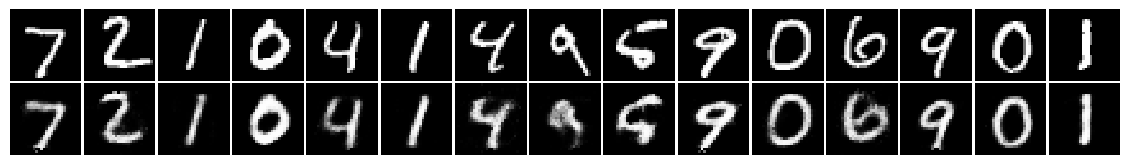

epoch 1 | iter 435 | loss 0.01605
epoch 1 | iter 440 | loss 0.01542


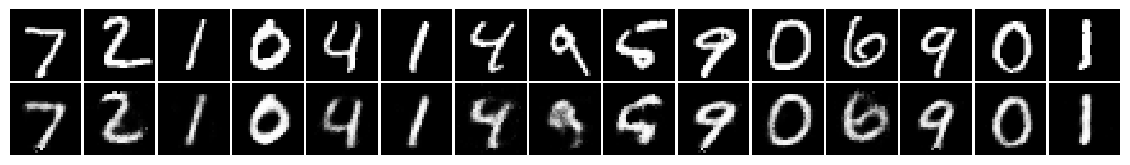

epoch 1 | iter 445 | loss 0.01559
epoch 1 | iter 450 | loss 0.01539


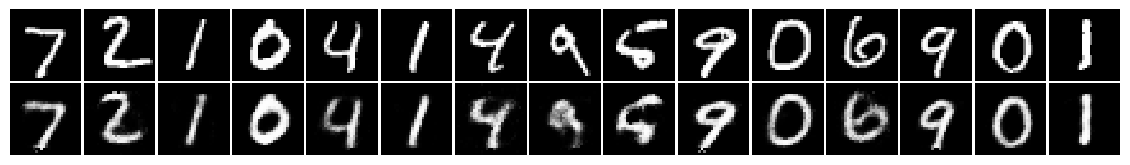

epoch 1 | iter 455 | loss 0.01484
epoch 1 | iter 460 | loss 0.01506


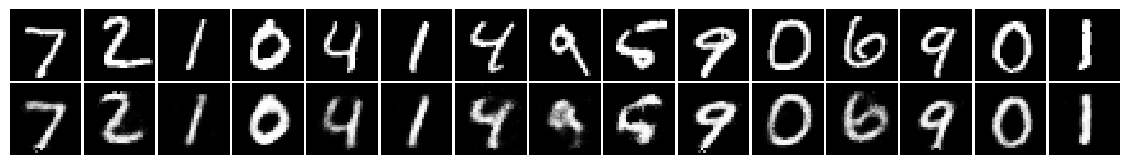

epoch 1 | iter 465 | loss 0.01585
epoch 1 | iter 470 | loss 0.01569


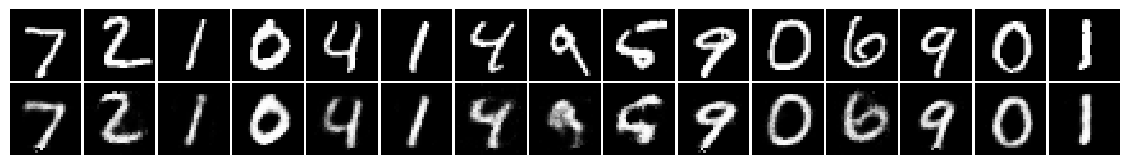

epoch 2 | iter 475 | loss 0.01538
epoch 2 | iter 480 | loss 0.01512


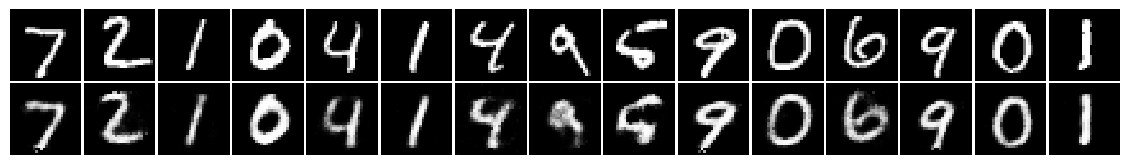

epoch 2 | iter 485 | loss 0.01479
epoch 2 | iter 490 | loss 0.01445


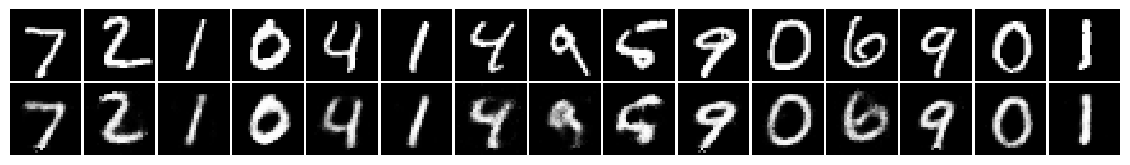

epoch 2 | iter 495 | loss 0.01517
epoch 2 | iter 500 | loss 0.01477


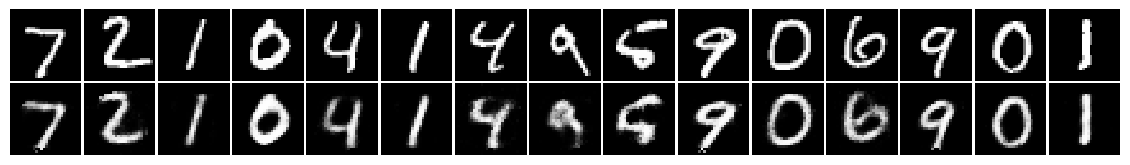

In [16]:
# we will be training the model for 500 iterations

ae = AutoEncoder(inp_shape=(1, 28, 28), hidden_dim=512, out_dim=20)

train_ae(train_dl, valid_dl, ae, 50, 500)

## Training Vanilla Variational Auto Encoder

Now we will reuse Encoder and Decoder modules from above to build a simple variational auto encoder 

In [17]:
class VariationalAutoEncoder(nn.Module):
    def __init__(self, inp_shape: Tuple[int, int], hidden_dim: int, out_dim: int, z_dim: int):
        super().__init__()
        
        self.enc = Encoder(inp_shape, hidden_dim, out_dim)
        self.dec = Decoder(inp_shape, hidden_dim, out_dim)
        
        self.mu     = nn.Linear(out_dim, z_dim)
        self.logvar = nn.Linear(out_dim, z_dim)
        
        self.fc = nn.Linear(z_dim, out_dim)
        
        init_weights(self)
        
    def encode(self, x):
        """This function takes x and produces mean and log(variance) for approximate posterior Q(z|x)"""
        
        enc = self.enc(x)
        
        mu, logvar = self.mu(enc), self.logvar(enc)
        
        return mu, logvar
        
    def sample_z(self, mu, logvar):
        """This function takes mean and log(variance) and applies reparametrization trick."""
        
        eps = torch.rand_like(mu)
        
        return mu + eps * torch.exp(0.5 * logvar)
    
    def decode(self, z):
        """This function accepts z - latent vector and produces reconstruction of original input."""
        
        return self.dec(self.fc(z))
        
    def forward(self, x):
        
        mu, logvar = self.encode(x)
        
        z = self.sample_z(mu, logvar)
        
        return self.decode(z)

In [18]:
m = VariationalAutoEncoder(inp_shape=(1, 28, 28), hidden_dim=512, out_dim=256, z_dim=2)
m

VariationalAutoEncoder(
  (enc): Encoder(
    (enc): Sequential(
      (0): Flatten()
      (1): Linear(in_features=784, out_features=512, bias=True)
      (2): ReLU()
      (3): Linear(in_features=512, out_features=256, bias=True)
    )
  )
  (dec): Decoder(
    (dec): Sequential(
      (0): Linear(in_features=256, out_features=512, bias=True)
      (1): ReLU()
      (2): Linear(in_features=512, out_features=784, bias=True)
    )
  )
  (mu): Linear(in_features=256, out_features=2, bias=True)
  (logvar): Linear(in_features=256, out_features=2, bias=True)
  (fc): Linear(in_features=2, out_features=256, bias=True)
)

In [20]:
def elbo_loss(inp, tar, mu, logvar, alpha: float = 1, beta: float = 1):
    """This function defines ELBO loss, KL DIV + RECONSTRUCTION."""
    
    recon_loss = nn.functional.mse_loss(inp, tar, reduction='none').sum(dim=(1, 2, 3))
            
    kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=-1)

    loss = torch.mean(alpha * kld_loss + beta * recon_loss)
    
    return loss, torch.mean(recon_loss), torch.mean(kld_loss)

def train_vae(train_dl: DataLoader, 
              valid_dl: DataLoader,
              model: nn.Module,
              n_epochs: int,
              max_iters: int = -1):
    
    LOG_INTERVAL = 20
    SUMMARY_INTERVAL = 100
    
    model = model.cuda()
    
    model.train()
    
    optim = torch.optim.Adam(model.parameters(), lr=1e-3)
    
    acc_recon_loss, acc_kld_loss, acc_loss = 0, 0, 0
    
    i = 1
    for epoch in range(n_epochs):
        for x, y in train_dl:
            
            optim.zero_grad()
            
            x = x.cuda()

            mu, logvar = model.encode(x)
            
            z = model.sample_z(mu, logvar)
        
            x_recon = model.decode(z)
        
            loss, recon_loss, kld_loss = elbo_loss(x_recon, x, mu, logvar, alpha=1, beta=1)

            acc_recon_loss += recon_loss.item()
            acc_kld_loss += kld_loss.item()
            acc_loss += loss.item()
            
            loss.backward()
            
            optim.step()
            
            if (i + 1) % LOG_INTERVAL == 0:
                
                print('epoch %d | iter %d | loss %.5f | KL loss %.5f | recon loss %.5f ' % 
                      (epoch + 1, i + 1, acc_loss / LOG_INTERVAL, acc_kld_loss / LOG_INTERVAL, acc_recon_loss / LOG_INTERVAL))
                
                acc_recon_loss, acc_kld_loss, acc_loss = 0, 0, 0
                
            if (i + 1) % SUMMARY_INTERVAL == 0:
                show_summary(valid_dl, model)
                
            i += 1
            
            if i == max_iters:
                return

epoch 1 | iter 20 | loss 97.31065 | KL loss 5.05985 | recon loss 92.25080 
epoch 1 | iter 40 | loss 50.70443 | KL loss 1.61769 | recon loss 49.08674 
epoch 1 | iter 60 | loss 42.14244 | KL loss 2.46130 | recon loss 39.68113 
epoch 1 | iter 80 | loss 36.30953 | KL loss 3.01926 | recon loss 33.29027 
epoch 1 | iter 100 | loss 32.54368 | KL loss 3.38414 | recon loss 29.15953 


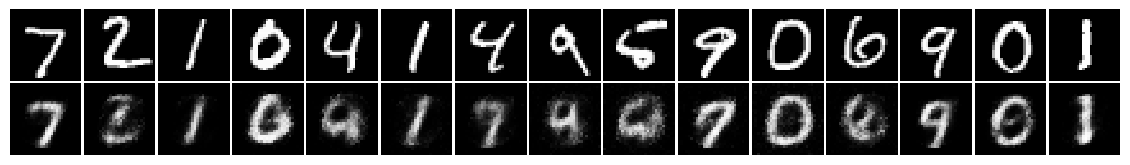

epoch 1 | iter 120 | loss 30.69053 | KL loss 3.70267 | recon loss 26.98785 
epoch 1 | iter 140 | loss 28.70821 | KL loss 3.87638 | recon loss 24.83183 
epoch 1 | iter 160 | loss 27.57222 | KL loss 4.09669 | recon loss 23.47553 
epoch 1 | iter 180 | loss 26.54970 | KL loss 4.22955 | recon loss 22.32015 
epoch 1 | iter 200 | loss 26.07737 | KL loss 4.31275 | recon loss 21.76462 


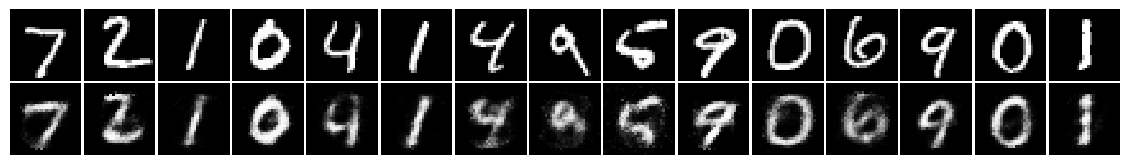

epoch 1 | iter 220 | loss 25.31701 | KL loss 4.39892 | recon loss 20.91809 
epoch 1 | iter 240 | loss 24.40836 | KL loss 4.43403 | recon loss 19.97433 
epoch 1 | iter 260 | loss 24.16545 | KL loss 4.49071 | recon loss 19.67474 
epoch 1 | iter 280 | loss 23.63438 | KL loss 4.48170 | recon loss 19.15268 
epoch 1 | iter 300 | loss 23.62544 | KL loss 4.49075 | recon loss 19.13470 


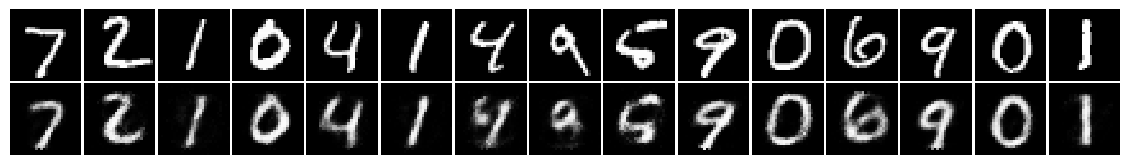

epoch 1 | iter 320 | loss 23.57505 | KL loss 4.56092 | recon loss 19.01413 
epoch 1 | iter 340 | loss 23.09293 | KL loss 4.52939 | recon loss 18.56354 
epoch 1 | iter 360 | loss 23.02115 | KL loss 4.56308 | recon loss 18.45806 
epoch 1 | iter 380 | loss 22.46097 | KL loss 4.61203 | recon loss 17.84894 
epoch 1 | iter 400 | loss 22.67899 | KL loss 4.62965 | recon loss 18.04934 


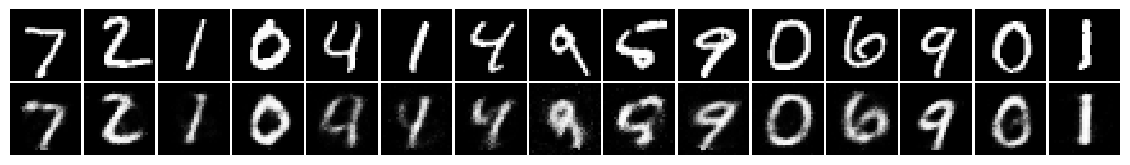

epoch 1 | iter 420 | loss 22.17717 | KL loss 4.63319 | recon loss 17.54398 
epoch 1 | iter 440 | loss 22.03545 | KL loss 4.64656 | recon loss 17.38889 
epoch 1 | iter 460 | loss 21.86387 | KL loss 4.63628 | recon loss 17.22759 
epoch 2 | iter 480 | loss 21.80278 | KL loss 4.65361 | recon loss 17.14917 
epoch 2 | iter 500 | loss 21.65168 | KL loss 4.70153 | recon loss 16.95015 


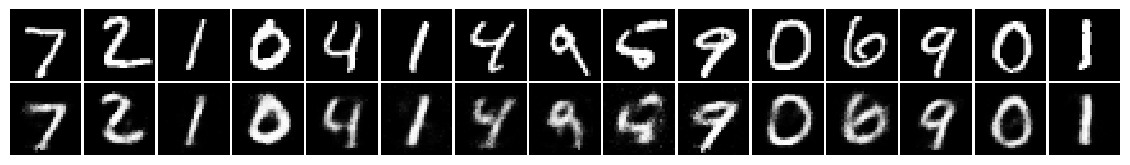

In [21]:
# we will be training the model for 500 iterations

vae = VariationalAutoEncoder(inp_shape=(1, 28, 28), hidden_dim=512, out_dim=256, z_dim=20)

train_vae(train_dl, valid_dl, vae, 50, 500)

### Visualizing Latent Space

In this section we will work through several visualizations of above models to develop good intuition how these models work.  

In all below cases we will be using models with 2D latent space since its directly plottable without need of dimensionality reduction techniques, such as PCA. 

Besides, we will use pre-trained model weights because 2D latent space model training requires approx. 50 epochs on the data that would take long time to do it here.



In [25]:
if not os.path.exists('ae-20.model'):
    !wget https://maxinai-public-datasets.s3.eu-central-1.amazonaws.com/workshop-amld2020/ae-20.model

--2020-01-19 14:23:44--  https://maxinai-public-datasets.s3.eu-central-1.amazonaws.com/workshop-amld2020/ae-20.model
Resolving maxinai-public-datasets.s3.eu-central-1.amazonaws.com (maxinai-public-datasets.s3.eu-central-1.amazonaws.com)... 52.219.73.160
Connecting to maxinai-public-datasets.s3.eu-central-1.amazonaws.com (maxinai-public-datasets.s3.eu-central-1.amazonaws.com)|52.219.73.160|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3228321 (3.1M) [binary/octet-stream]
Saving to: ‘ae-20.model’

ae-20.model         100%[===================>]   3.08M  4.53MB/s    in 0.7s    

2020-01-19 14:23:45 (4.53 MB/s) - ‘ae-20.model’ saved [3228321/3228321]



In [26]:
# loading pre-trained Auto Encoder with 2D latent space

ae = AutoEncoder(inp_shape=(1, 28, 28), hidden_dim=512, out_dim=2)
ae.load_state_dict(torch.load('ae-20.model'))
ae.eval()

AutoEncoder(
  (ae): Sequential(
    (0): Encoder(
      (enc): Sequential(
        (0): Flatten()
        (1): Linear(in_features=784, out_features=512, bias=True)
        (2): ReLU()
        (3): Linear(in_features=512, out_features=2, bias=True)
      )
    )
    (1): Decoder(
      (dec): Sequential(
        (0): Linear(in_features=2, out_features=512, bias=True)
        (1): ReLU()
        (2): Linear(in_features=512, out_features=784, bias=True)
      )
    )
  )
)

We will start by visualizing the clusters of digits by plotting latent vectors of datapoints from validation set.

In [27]:
# here we will go over validation set and generate latent representation of every data point by using encoder part 
# of the model. X and Y coordinates of this latent vectors, along with the label are stored in Dataframe.

z, labels = [], []
for i, (x, y) in enumerate(valid_dl):
    mu = ae.ae[0](x).detach()
    z.append(mu)
    labels.append(y)
z = torch.cat(z, dim=0)
labels = torch.cat(labels, dim=0)

df = pd.DataFrame({'x': z[:,0].numpy(), 
                   'y': z[:,1].numpy(),
                   'label': labels.numpy()})

df.head()

x         y  label
0  1.105610  4.956746      7
1 -0.581305 -0.078693      2
2 -6.466476  6.207766      1
3  1.150499 -0.204559      0
4  1.584186  2.257911      4

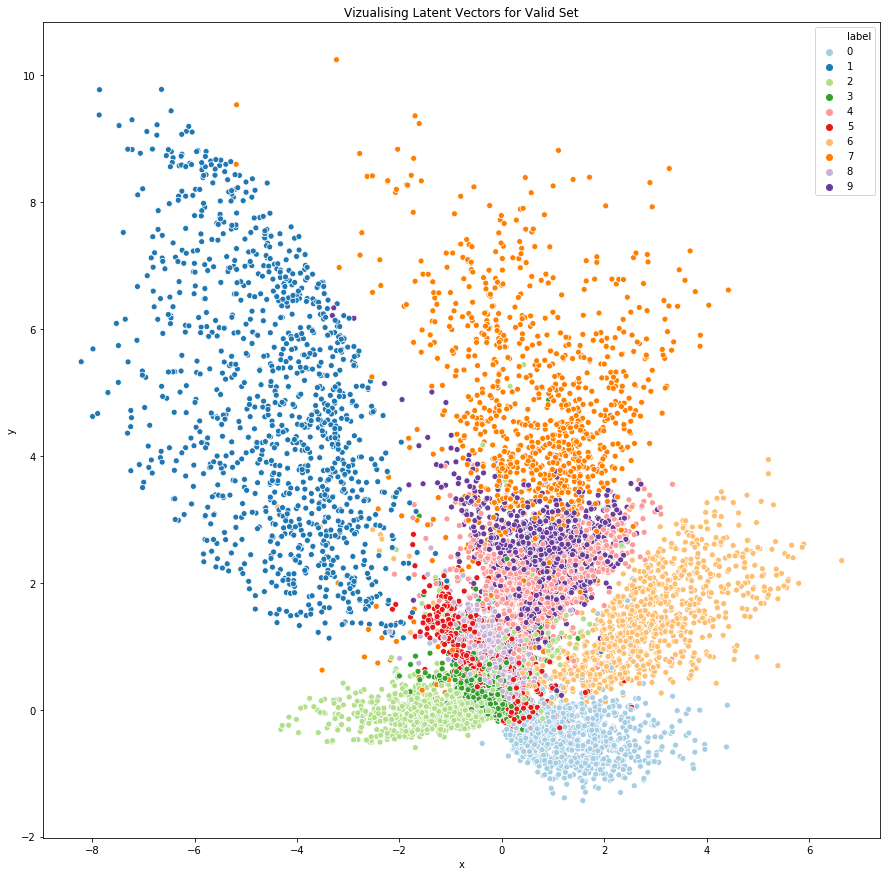

In [28]:
# plotting the dataframe by assigning different color to different digit (label)

plt.figure(figsize=(15, 15))
sns.scatterplot(x="x", y="y", hue="label", palette=sns.color_palette("Paired", 10), data=df, legend="full")
plt.title('Vizualising Latent Vectors for Valid Set');

Now we will do the same visualization for variational auto-encoder

In [29]:
if not os.path.exists('vae-60.model'):
    !wget https://maxinai-public-datasets.s3.eu-central-1.amazonaws.com/workshop-amld2020/vae-60.model

--2020-01-19 14:25:30--  https://maxinai-public-datasets.s3.eu-central-1.amazonaws.com/workshop-amld2020/vae-60.model
Resolving maxinai-public-datasets.s3.eu-central-1.amazonaws.com (maxinai-public-datasets.s3.eu-central-1.amazonaws.com)... 52.219.75.1
Connecting to maxinai-public-datasets.s3.eu-central-1.amazonaws.com (maxinai-public-datasets.s3.eu-central-1.amazonaws.com)|52.219.75.1|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4277671 (4.1M) [binary/octet-stream]
Saving to: ‘vae-60.model’

vae-60.model        100%[===================>]   4.08M  5.28MB/s    in 0.8s    

2020-01-19 14:25:31 (5.28 MB/s) - ‘vae-60.model’ saved [4277671/4277671]



In [30]:
# loading pre-trained Variational Auto Encoder with 2D latent space

vae = VariationalAutoEncoder(inp_shape=(1, 28, 28), hidden_dim=512, out_dim=256, z_dim=2)
vae.load_state_dict(torch.load('vae-60.model'))
vae.eval()

VariationalAutoEncoder(
  (enc): Encoder(
    (enc): Sequential(
      (0): Flatten()
      (1): Linear(in_features=784, out_features=512, bias=True)
      (2): ReLU()
      (3): Linear(in_features=512, out_features=256, bias=True)
    )
  )
  (dec): Decoder(
    (dec): Sequential(
      (0): Linear(in_features=256, out_features=512, bias=True)
      (1): ReLU()
      (2): Linear(in_features=512, out_features=784, bias=True)
    )
  )
  (mu): Linear(in_features=256, out_features=2, bias=True)
  (logvar): Linear(in_features=256, out_features=2, bias=True)
  (fc): Linear(in_features=2, out_features=256, bias=True)
)

In [31]:
def viz_vae_clusters(vae: nn.Module):

    vae.cuda()
    z, labels = [], []
    with torch.no_grad():
        for i, (x, y) in enumerate(valid_dl):
            x = x.cuda()
            mu, _ = vae.encode(x)
            z.append(mu.cpu())
            labels.append(y)
    z = torch.cat(z, dim=0)
    labels = torch.cat(labels, dim=0)

    df = pd.DataFrame({'x': z[:,0].numpy(), 
                  'y': z[:,1].numpy(),
                  'label': labels.numpy()})

    plt.figure(figsize=(15, 15))
    sns.scatterplot(x="x", y="y", hue="label", palette=sns.color_palette("Paired", 10), data=df, legend="full")
    plt.title('Vizualising Latent Vectors for Valid Set');

As you will see from below plot, point cloud of latent vectors has circular shape centered at origin as opposed to 
Auto Encoder case. This behaviour is imposed by KL Divergence component of the loss, that forces latent distribution to be close to the isotropic Gaussian.

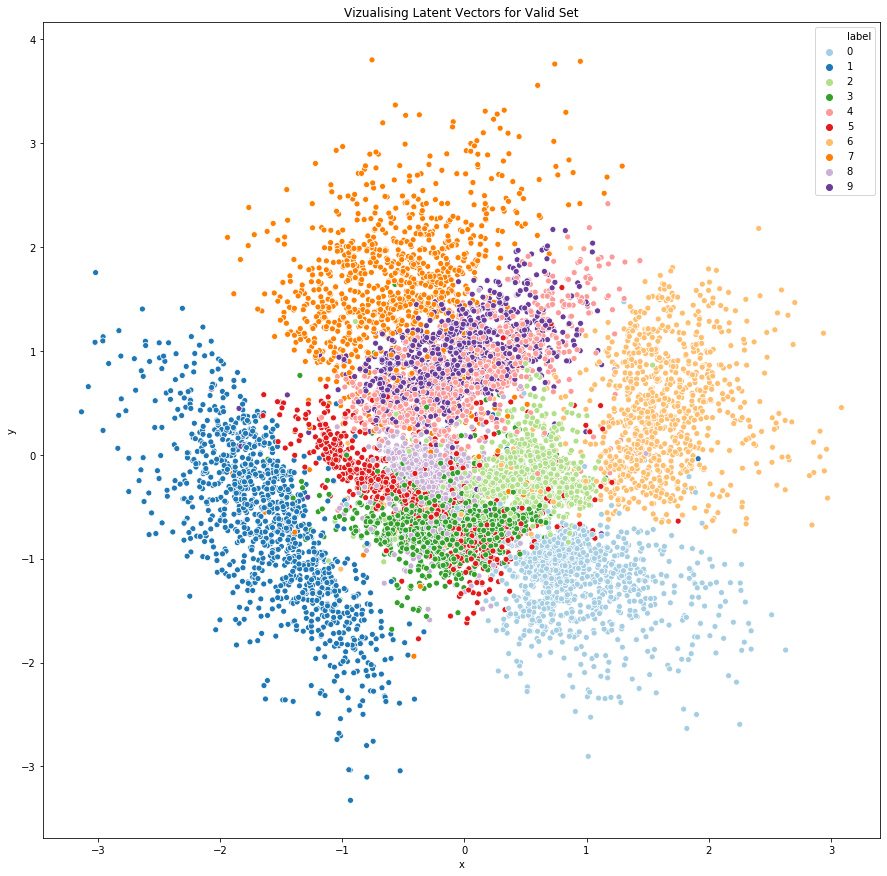

In [32]:
viz_vae_clusters(vae)

Now we will see what happens if we remove KL Divergence term and only use reconstruction loss.

In [33]:
if not os.path.exists('vae-60-kl0.model'):
    !wget https://maxinai-public-datasets.s3.eu-central-1.amazonaws.com/workshop-amld2020/vae-60-kl0.model

--2020-01-19 14:26:31--  https://maxinai-public-datasets.s3.eu-central-1.amazonaws.com/workshop-amld2020/vae-60-kl0.model
Resolving maxinai-public-datasets.s3.eu-central-1.amazonaws.com (maxinai-public-datasets.s3.eu-central-1.amazonaws.com)... 52.219.72.160
Connecting to maxinai-public-datasets.s3.eu-central-1.amazonaws.com (maxinai-public-datasets.s3.eu-central-1.amazonaws.com)|52.219.72.160|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4277671 (4.1M) [binary/octet-stream]
Saving to: ‘vae-60-kl0.model’

vae-60-kl0.model    100%[===================>]   4.08M  5.32MB/s    in 0.8s    

2020-01-19 14:26:32 (5.32 MB/s) - ‘vae-60-kl0.model’ saved [4277671/4277671]



In [34]:
# loading trained Variational AutoEncoder with 2D latent space and without KL component

vae_kl = VariationalAutoEncoder(inp_shape=(1, 28, 28), hidden_dim=512, out_dim=256, z_dim=2)
vae_kl.load_state_dict(torch.load('vae-60-kl0.model'))
vae_kl.eval()

VariationalAutoEncoder(
  (enc): Encoder(
    (enc): Sequential(
      (0): Flatten()
      (1): Linear(in_features=784, out_features=512, bias=True)
      (2): ReLU()
      (3): Linear(in_features=512, out_features=256, bias=True)
    )
  )
  (dec): Decoder(
    (dec): Sequential(
      (0): Linear(in_features=256, out_features=512, bias=True)
      (1): ReLU()
      (2): Linear(in_features=512, out_features=784, bias=True)
    )
  )
  (mu): Linear(in_features=256, out_features=2, bias=True)
  (logvar): Linear(in_features=256, out_features=2, bias=True)
  (fc): Linear(in_features=2, out_features=256, bias=True)
)

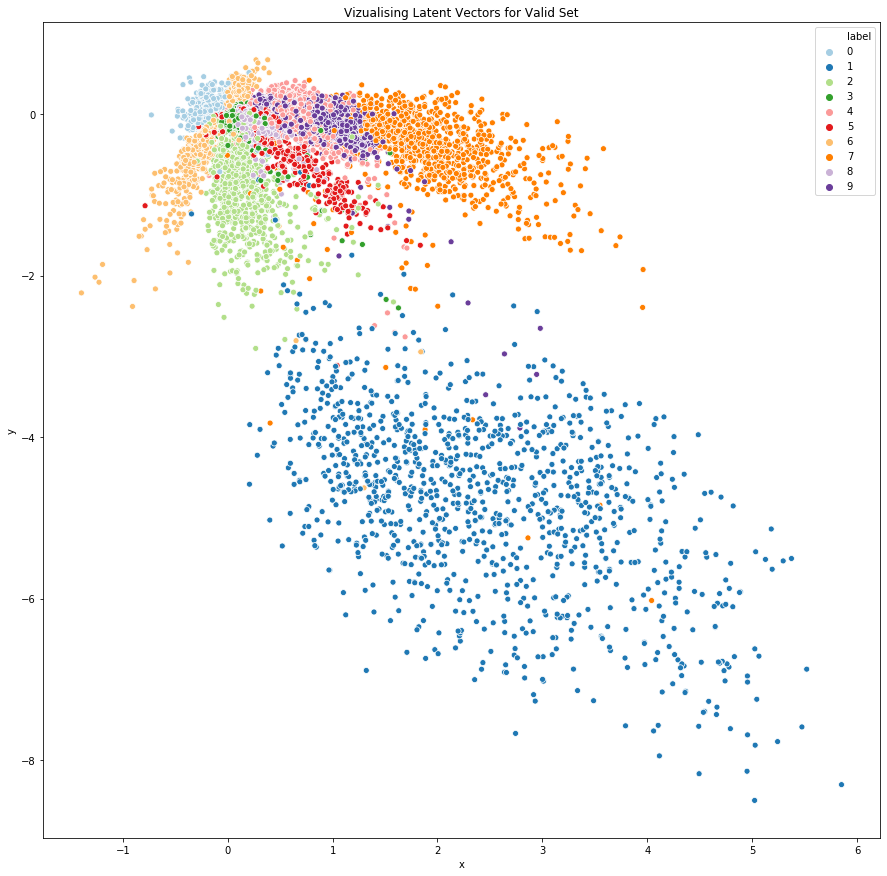

In [35]:
viz_vae_clusters(vae_kl)

Now we will show that latent space of Variational Auto-Encoder is continuous, i.e. close latent vectors produce similar looking images at the output.

We will do it by visualizing whole 2D space at once (run the below cell to see what it means).

We will exploit the fact that our latent vectors are distributed somewhat similar to 2D isotropic gaussian centered at origin (refer above plots). Having said this, we need to generate 2D meshgrid where distribution of points correspond to 2D Gaussian.


To do this, we gonna first generate 2D meshgrid in $[0, 1]^2$ unit square and use inverse CDF (Comulative Distribution Function) of Gaussian to translate our meshgrid to the latent space.

Finally, we decode every point in latent space and visualize output images as 2D plot.



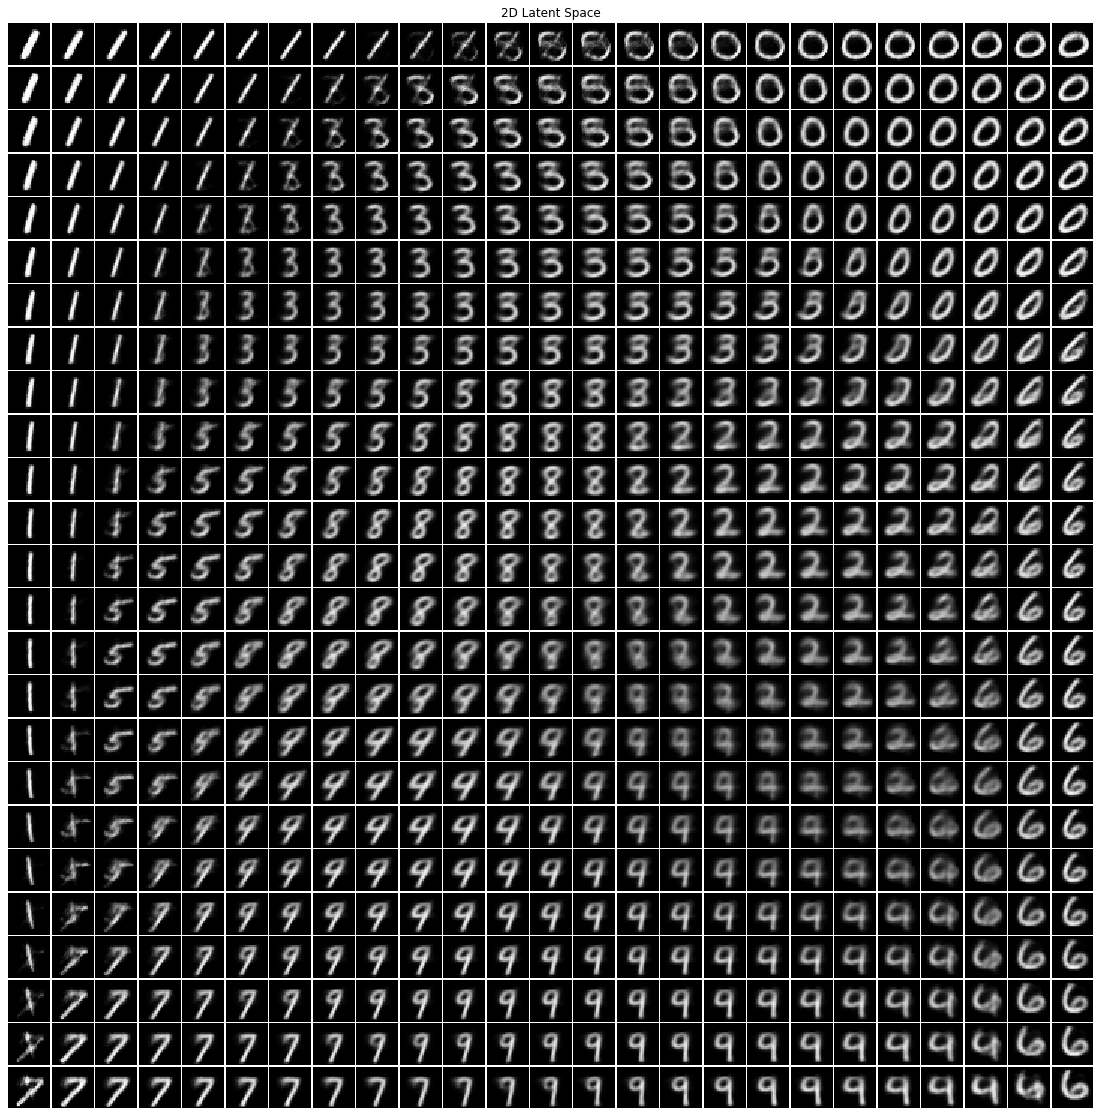

In [36]:
def draw_mnist_manifold_vae(model: nn.Module, size: int = 20):
    """This function takes a trained VAE with z_dim=2 and visualizes its latent space."""

    # generate a 2D point cloud of latent space using inverse CDF of Standard Gaussian.
    x_axes = ndist.ppf(np.linspace(0.05, 0.95, size))
    y_axes = ndist.ppf(np.linspace(0.05, 0.95, size))

    # preparing input to decoder.
    z = []
    for i, y in enumerate(x_axes):
        for j, x in enumerate(y_axes):
            z.append(torch.Tensor([x, y]))
    z = torch.stack(z)
    
    # decoding latent vectors
    preds = model.decode(z).detach()
    
    # rendering a single image from predictions.
    grid = make_grid(preds, pad_value=1, padding=1, nrow=size)[0].numpy()
    
    # showing the image.
    plt.figure(figsize=(20, 20))
    plt.imshow(grid, cmap='gray')
    plt.axis('off')
    plt.title('2D Latent Space')
    plt.show()

draw_mnist_manifold_vae(vae.cpu(), size=25);

Doing similar visualization on Auto Encoder produces bad result, because the latent space usually isn't continuous.

More specifically, in some regions of space we get outputs that <b>don't represent valid digits</b>.

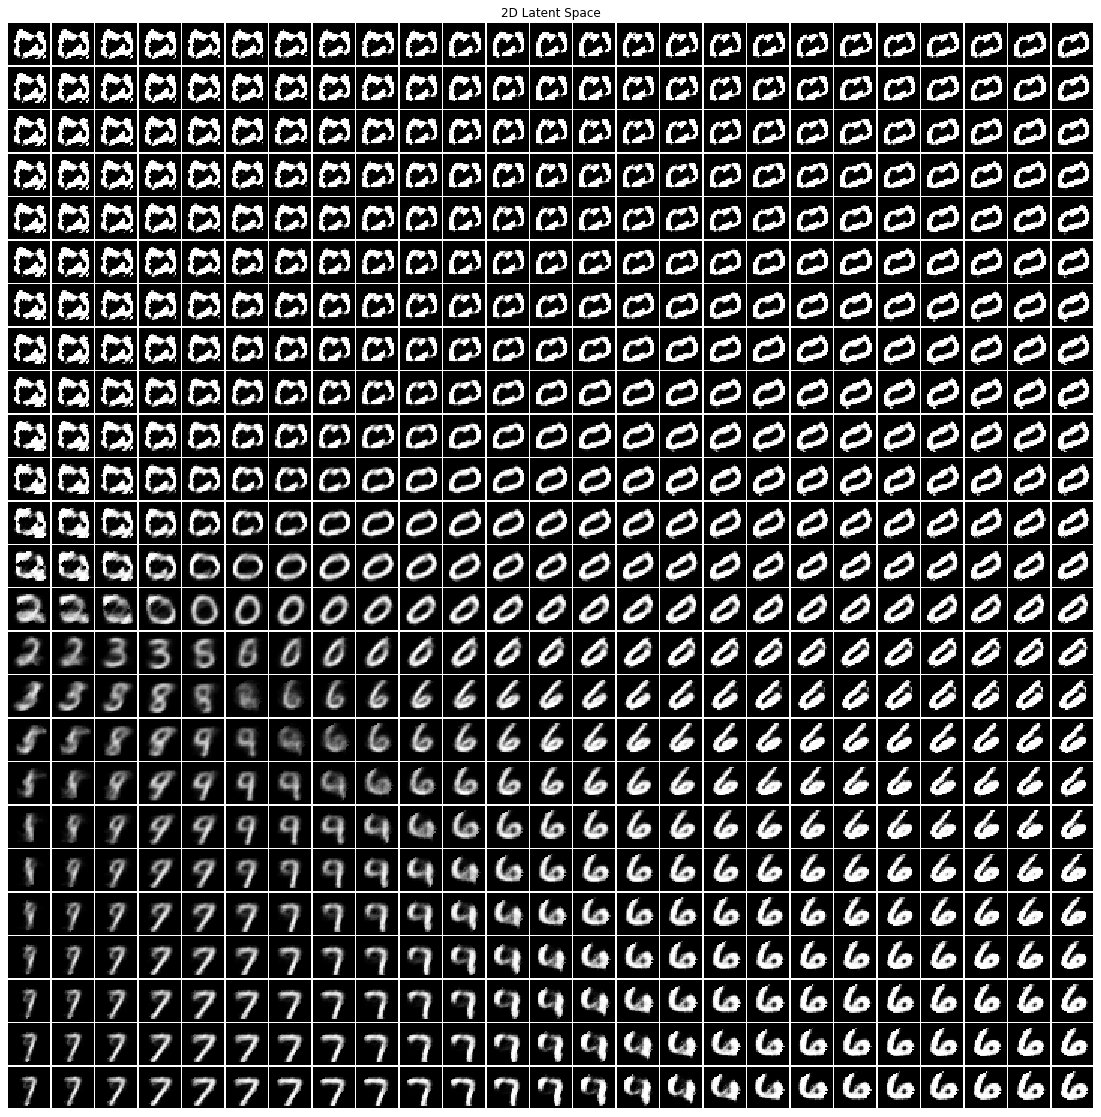

In [37]:
def draw_mnist_manifold_ae(model: nn.Module, size: int = 20):
    """This function takes a trained VAE with z_dim=2 and visualizes its latent space."""

    # generate a 2D point cloud of latent space using inverse CDF of Standard Gaussian.
    x_axes = np.linspace(-8, 6, size)
    y_axes = np.linspace(-1.5, 10, size)

    # assembling the latent vector of shape (size^2, 2) to be fed into the decoder.
    z = []
    for i, y in enumerate(x_axes):
        for j, x in enumerate(y_axes):
            z.append(torch.Tensor([x, y]))
    z = torch.stack(z)
    
    # generating predictions
    preds = model.ae[1](z).detach()
    
    # rendering a single image from predictions.
    grid = make_grid(preds, pad_value=1, padding=1, nrow=size)[0].numpy()
    
    # showing the image.
    plt.figure(figsize=(20, 20))
    plt.imshow(grid, cmap='gray')
    plt.axis('off')
    plt.title('2D Latent Space')
    plt.show()
    
draw_mnist_manifold_ae(ae.cpu(), 25)

## Sampling from VAE

One of the goals of generative models is being able to effectively sample from learned data distribution.  

In case of VAE, we take trained model, remove its encoder, and use decoder to transform gaussian noise into data point.

In [38]:
# generate 100 gaussian noise vectors

z = torch.empty(100, 2).normal_(0, 1)
z.shape

torch.Size([100, 2])

In [40]:
# decode the noise vectors

images = vae.decode(z)

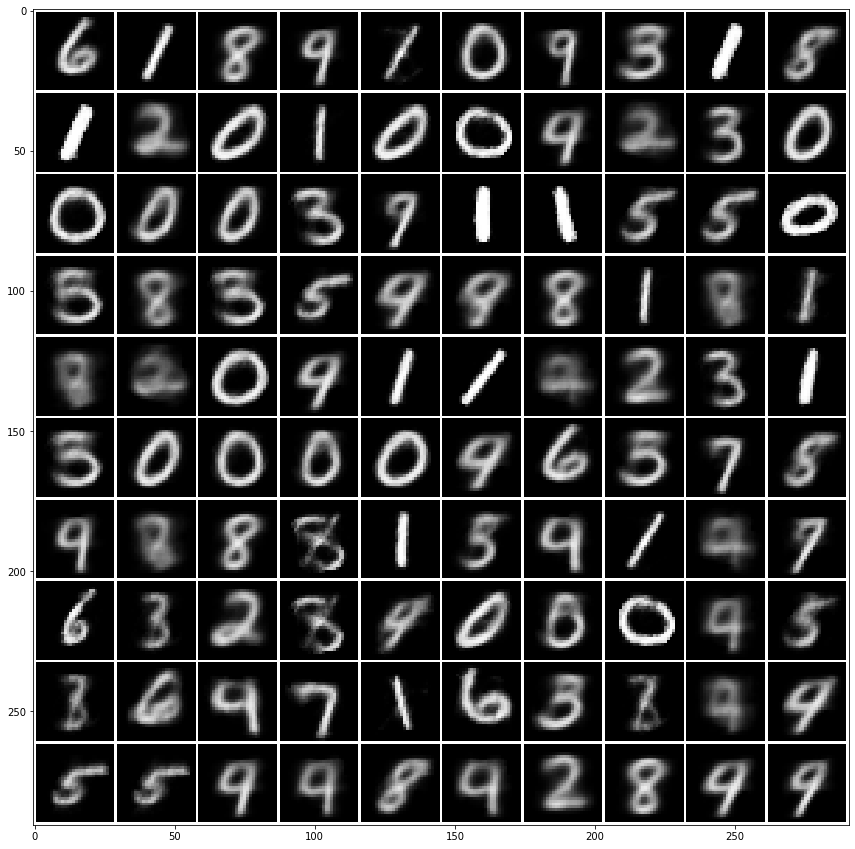

In [41]:
# plot the result

grid = make_grid(images, pad_value=1, padding=1, nrow=10)[0].detach().numpy()
plt.figure(figsize=(15, 15))
plt.imshow(grid, cmap='gray');

Continuity of latent space implies certain <b>robustness</b> agains noise.  

We can take latent vector corresponding to some digit, add small noise to it and still get output very similar to that digit.

In [43]:
# here we calculate average latent vector for every digit 0-9.
# average is taken to make sure we have representative vector, i.e we are somewhere close to the centroid of that digit's cluster.

locs = [torch.zeros(1, 1, 2) for _ in range(10)] # list for keeping latent vectors corresponding to digits 0-9
locs_cnt = [0] * 10 # list for keeping counts of latent vectors per digits. 

for i, (x, y) in enumerate(valid_dl.dataset):
    mu, _ = vae.encode(x.unsqueeze(0))
    locs[y] += mu
    locs_cnt[y] += 1
    if i > 500:
        break
        
for i in range(len(locs)): locs[i] /= locs_cnt[i]

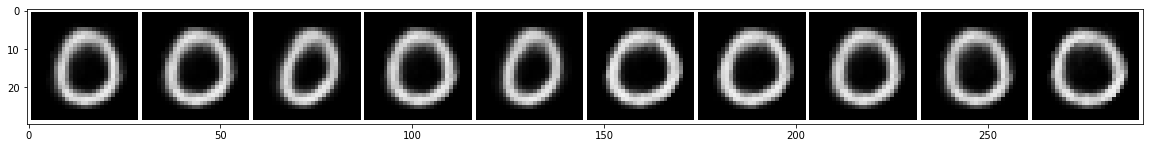

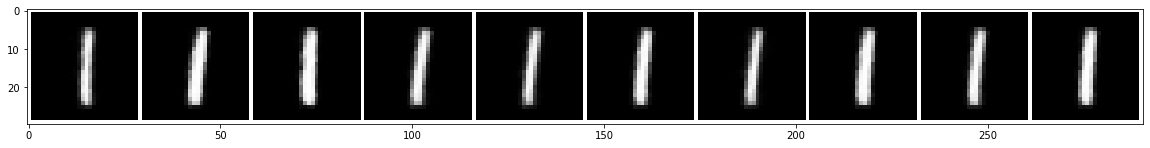

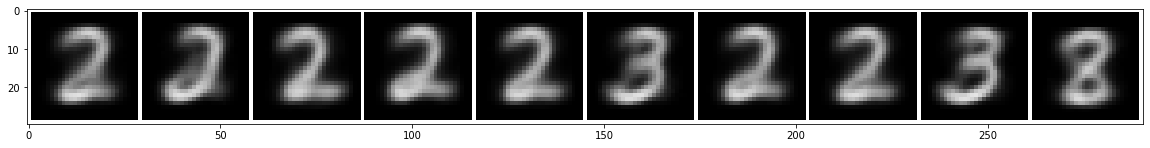

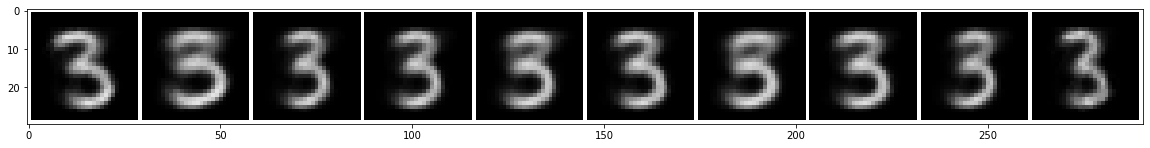

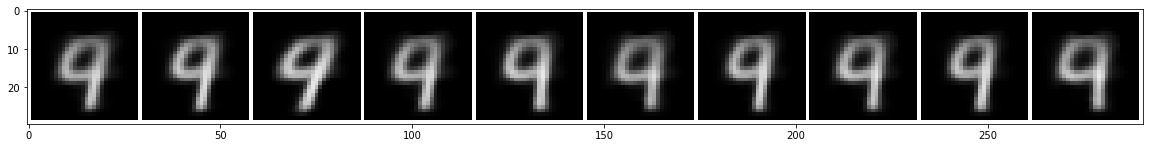

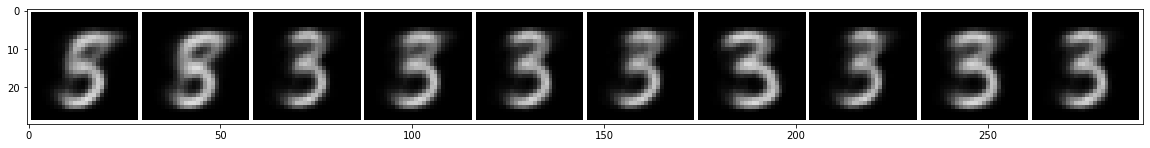

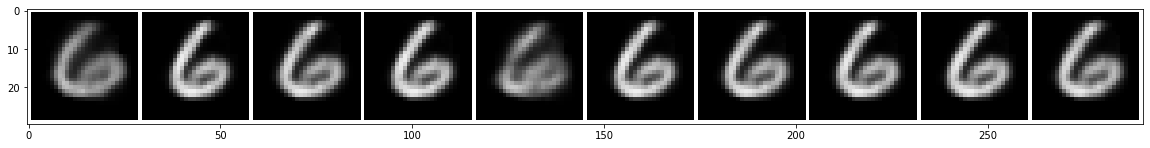

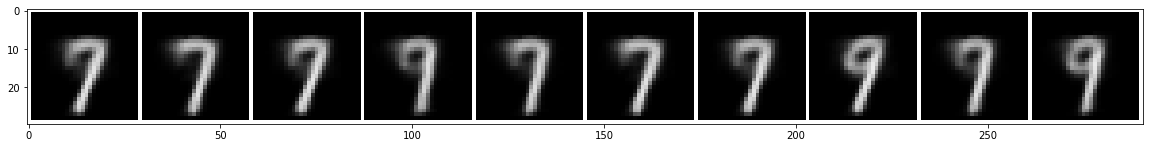

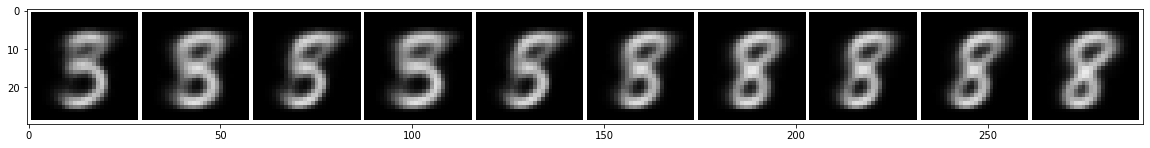

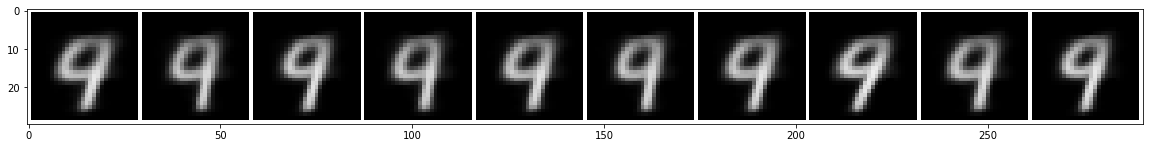

In [44]:
# we show how to generate same digit in different "handwriting" by taking average vector of that 
# digit and adding small noise. 

for i in range(10):
    x_recon = []
    for j in range(10):
        loc = locs[i].clone()
        loc += torch.empty_like(loc).normal_()/8
        x_recon.append(vae.decode(loc))
        
    x_recon = torch.cat(x_recon)
    
    grid = make_grid(x_recon, pad_value=1, padding=1, nrow=20)[0].detach().numpy()
    plt.figure(figsize=(20, 5))
    plt.imshow(grid, cmap='gray')
    plt.show()